<a href="https://colab.research.google.com/github/anushkaa-ambuj/Knowledge-Distillation-of-Chest-X-Ray-Images/blob/main/HKD_FashionMNIST-Task%201(ii).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Teacher: DenseNet 121 <br>
Senior Student: Resnet 34 <br>
Student: MobileNet

Dataset: Fashion MNIST</b>

## Import Dependancies

In [ ]:
!pip install torchinfo

## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torchinfo
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.utils import make_grid
#import timer

## Define the device to use

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Transformations

Currently, not utilzing any data transformations

In [ ]:
# Define the transforms for data augmentation
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

## Import the Dataset
### Splitting the Dataset

In [ ]:
# Load the CIFAR-10 dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True,
                                  download=True, transform=transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root='./data', train=False,
                                 download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 12217067.38it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 207907.67it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3937933.69it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4762301.94it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_data, val_data = torch.utils.data.random_split(train_dataset, [48000, 12000])

## Data Loader

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False)

## Teacher Model

### Initializing the Teacher model

In [ ]:
# Load the pre-trained DenseNet model
teacher = models.densenet121(pretrained=True)

# Change the number of input channels in the first layer to 1
teacher.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

# Add dropout layers to the classifier
num_ftrs = teacher.classifier.in_features
teacher.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),  # Add a new fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 10)  # Fashion MNIST has 10 classes
)

teacher.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#teacher = models.densenet121(pretrained=True)
#num_ftrs = teacher.classifier.in_features
#teacher.classifier = nn.Linear(num_ftrs, 10)
#teacher.load_state_dict(torch.load('model_teacher'))
#teacher.to(device)
#teacher.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Teacher Model Summary

In [ ]:
torchinfo.summary(teacher, (1, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DenseNet                                 [1, 1, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                        [1, 1, 224, 224]          [1, 1024, 14, 14]         --                        --                        --
│    └─Conv2d: 2-1                       [1, 1, 224, 224]          [1, 64, 224, 224]         576                       [3, 3]                    28,901,376
│    └─BatchNorm2d: 2-2                  [1, 64, 224, 224]         [1, 64, 224, 224]         128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 224, 224]         [1, 64, 224, 224]         --                        --                        --
│    └─MaxPool2d: 2-4                    [1, 64, 224, 224]         [1, 64, 112, 112]         -- 

### Train Teacher Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.001)

In [ ]:
epochs = 35

In [ ]:
train_loss = []; train_acc = []
val_loss = []; val_acc = []

for epoch in range(epochs):
    l1 = []; a1 = []
    l2 = []; a2 = []

    #start = timer()
    for i, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        output = teacher(img)

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == labels).item() / len(preds))
        a1.append(acc)

        loss = criterion(output, labels)
        l1.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for img, lbl in valloader:
        img = img.to(device)
        lbl = lbl.to(device)
        output = teacher(img)

        loss = criterion(output,lbl)
        l2.append(loss.item())

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == lbl).item() / len(preds))
        a2.append(acc)

    train_loss.append(np.mean(l1))
    val_loss.append(np.mean(l2))
    train_acc.append(np.mean(a1))
    val_acc.append(np.mean(a2))

    #end = timer()
    #time = end - start
    #time = time/60

    print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')
    #print(f'Epoch {epoch+1}: Train Loss==> {np.mean(train_loss):.2f} Train_Acc==> {np.mean(train_acc)*100 :.3f} % Val Loss==> {np.mean(val_loss):.2f} Val_Acc==> {np.mean(val_acc)*100 :.3f} % Time==> {time:.2f} mins')

Epoch 1: Train Loss==> 1.41 Train_Acc==> 60.056 % Val Loss==> 0.81  Val_Acc==> 75.615 %
Epoch 2: Train Loss==> 0.65 Train_Acc==> 78.848 % Val Loss==> 0.55  Val_Acc==> 81.142 %
Epoch 3: Train Loss==> 0.49 Train_Acc==> 83.269 % Val Loss==> 0.46  Val_Acc==> 83.959 %
Epoch 4: Train Loss==> 0.42 Train_Acc==> 85.231 % Val Loss==> 0.41  Val_Acc==> 85.655 %
Epoch 5: Train Loss==> 0.37 Train_Acc==> 86.898 % Val Loss==> 0.38  Val_Acc==> 86.245 %
Epoch 6: Train Loss==> 0.33 Train_Acc==> 88.188 % Val Loss==> 0.36  Val_Acc==> 86.976 %
Epoch 7: Train Loss==> 0.31 Train_Acc==> 88.875 % Val Loss==> 0.35  Val_Acc==> 87.832 %
Epoch 8: Train Loss==> 0.29 Train_Acc==> 89.815 % Val Loss==> 0.33  Val_Acc==> 88.406 %
Epoch 9: Train Loss==> 0.27 Train_Acc==> 90.494 % Val Loss==> 0.32  Val_Acc==> 88.414 %
Epoch 10: Train Loss==> 0.25 Train_Acc==> 91.106 % Val Loss==> 0.32  Val_Acc==> 88.788 %
Epoch 11: Train Loss==> 0.23 Train_Acc==> 91.640 % Val Loss==> 0.31  Val_Acc==> 89.171 %
Epoch 12: Train Loss==> 0.22 T

KeyboardInterrupt: ignored

### Epoch vs Loss, Epoch vs Accuracy Graphs

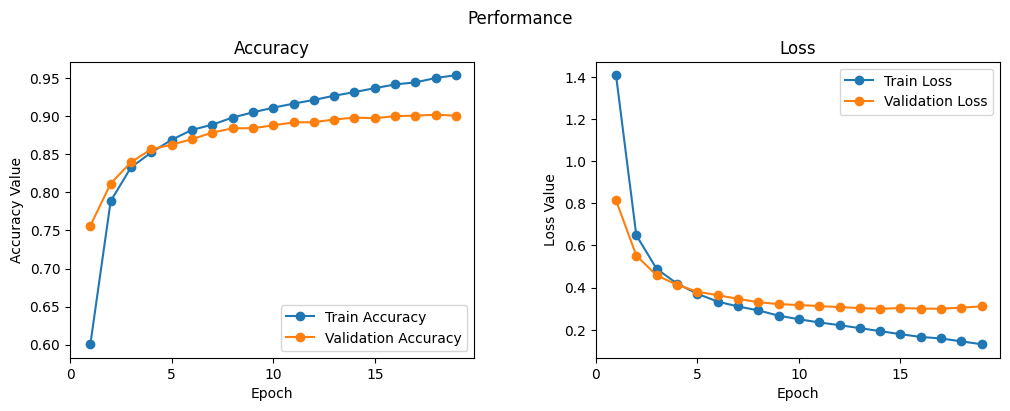

In [ ]:
epochs=19
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Classification Metrics & Confusion Matrix

In [ ]:
classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = teacher(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.8944
Confusion Matrix: 
 [[831   2  16  29   5   0 106   0  11   0]
 [  1 967   3  20   4   0   2   0   3   0]
 [ 12   0 814  14  71   0  87   0   2   0]
 [ 24   6  12 903  26   0  27   0   2   0]
 [  2   2  42  30 837   0  85   0   2   0]
 [  1   0   0   0   0 973   0  19   2   5]
 [104   2  56  39  64   0 722   0  13   0]
 [  0   0   0   0   0  17   0 957   0  26]
 [  4   0   2   2   3   1  10   3 973   2]
 [  0   0   0   0   0   4   1  28   0 967]]
Performance Report: 
               precision    recall  f1-score   support

 T-shirt/top       0.85      0.83      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.86      0.81      0.84      1000
       Dress       0.87      0.90      0.89      1000
        Coat       0.83      0.84      0.83      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.69      0.72      0.71      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.97

## Senior Student Model

### Initializing the model

In [ ]:
# Define ResNet34
senior = models.resnet34(pretrained=False)
senior.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = senior.fc.in_features
senior.fc = nn.Linear(num_ftrs, 10) # CIFAR-10 has 10 classes
senior.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torchinfo.summary(senior, (1, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ResNet                                   [1, 1, 224, 224]          [1, 10]                   --                        --                        --
├─Conv2d: 1-1                            [1, 1, 224, 224]          [1, 64, 112, 112]         3,136                     [7, 7]                    39,337,984
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
├─ReLU: 1-3                              [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         [1, 64, 56, 56]           --                        3                         --
├─Sequential: 1-5                        [1, 64, 56, 56]           [1, 64, 56, 56]           -- 

### Training the Senior Student model

In [ ]:
# Define the temperature for softening the logits
T = 4

# Define the optimizer for training the MobileNet model
optimizer2 = optim.SGD(senior.parameters(), lr=0.001)

In [ ]:
epochs2 = 35

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# Assuming you have defined the 'senior' and 'teacher' models and initialized them

def train_senior_teacher(senior, teacher, trainloader, valloader, epochs, T, device, optimizer2):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs2):
        l1 = []
        l2 = []
        a1 = []
        a2 = []

        for i, (img, labels) in enumerate(trainloader):
            img = img.to(device)
            labels = labels.to(device)
            output = senior(img)

            # Accuracy
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == labels).item() / len(preds))
            a1.append(acc)

            # Loss
            compare = teacher(img)
            pdist = F.softmax(compare / T, dim=1)
            soft_loss_teacher = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output / T, dim=1), pdist)
            loss = nn.CrossEntropyLoss()(output, labels)
            loss = 0.4 * loss + 0.6 * soft_loss_teacher
            l1.append(loss.item())

            # Backpropagation
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

        for img, lbl in valloader:
            img = img.to(device)
            lbl = lbl.to(device)
            output = senior(img)
            loss = nn.CrossEntropyLoss()(output, lbl)
            l2.append(loss.item())
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == lbl).item() / len(preds))
            a2.append(acc)

        train_loss.append(np.mean(l1))
        val_loss.append(np.mean(l2))
        train_acc.append(np.mean(a1))
        val_acc.append(np.mean(a2))

        print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_senior_teacher(senior, teacher, trainloader, valloader, epochs2, T, device, optimizer2)

Epoch 1: Train Loss==> 0.65 Train_Acc==> 61.979 % Val Loss==> 0.67  Val_Acc==> 75.823 %
Epoch 2: Train Loss==> 0.32 Train_Acc==> 78.769 % Val Loss==> 0.55  Val_Acc==> 80.062 %
Epoch 3: Train Loss==> 0.26 Train_Acc==> 82.404 % Val Loss==> 0.50  Val_Acc==> 81.981 %
Epoch 4: Train Loss==> 0.23 Train_Acc==> 84.296 % Val Loss==> 0.48  Val_Acc==> 82.754 %
Epoch 5: Train Loss==> 0.21 Train_Acc==> 85.665 % Val Loss==> 0.46  Val_Acc==> 83.918 %
Epoch 6: Train Loss==> 0.19 Train_Acc==> 86.969 % Val Loss==> 0.45  Val_Acc==> 84.466 %
Epoch 7: Train Loss==> 0.18 Train_Acc==> 88.062 % Val Loss==> 0.44  Val_Acc==> 84.666 %
Epoch 8: Train Loss==> 0.17 Train_Acc==> 89.150 % Val Loss==> 0.43  Val_Acc==> 85.298 %
Epoch 9: Train Loss==> 0.15 Train_Acc==> 89.985 % Val Loss==> 0.43  Val_Acc==> 85.572 %
Epoch 10: Train Loss==> 0.14 Train_Acc==> 90.927 % Val Loss==> 0.42  Val_Acc==> 85.514 %
Epoch 11: Train Loss==> 0.13 Train_Acc==> 91.596 % Val Loss==> 0.42  Val_Acc==> 85.655 %
Epoch 12: Train Loss==> 0.12 T

KeyboardInterrupt: ignored

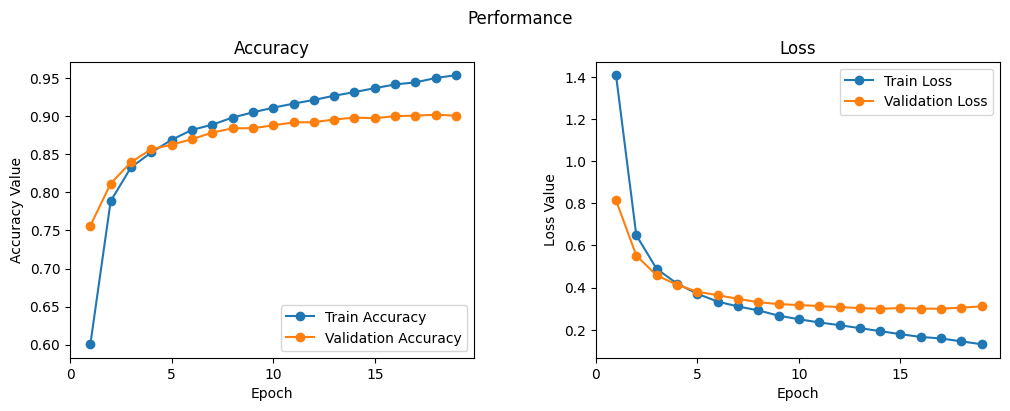

In [ ]:
epochs2=19
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs2+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.save(senior.state_dict(), 'model_senior')

In [ ]:
classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = senior(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.8472
Confusion Matrix: 
 [[794   2  29  36  12   3 108   0  15   1]
 [  4 960   4  23   4   0   4   0   1   0]
 [ 17   4 755  11 104   0 103   0   6   0]
 [ 33  16  17 848  39   1  42   0   4   0]
 [  2   1  89  35 773   0  90   0  10   0]
 [  0   1   0   1   0 934   1  44   2  17]
 [155   3 109  42  94   0 582   0  15   0]
 [  0   0   0   0   0  42   0 916   2  40]
 [  4   0   5   6   4   4  11   4 961   1]
 [  0   0   0   0   0  13   0  38   0 949]]
Performance Report: 
               precision    recall  f1-score   support

 T-shirt/top       0.79      0.79      0.79      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.75      0.76      0.75      1000
       Dress       0.85      0.85      0.85      1000
        Coat       0.75      0.77      0.76      1000
      Sandal       0.94      0.93      0.94      1000
       Shirt       0.62      0.58      0.60      1000
     Sneaker       0.91      0.92      0.92      1000
         Bag       0.95

## Student Model

### Initializing the model

In [ ]:
# Define the MobileNet architecture
student = models.mobilenet_v2(pretrained=False)
student.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)  # Change input channels to 1
num_ftrs_mobilenet = student.classifier[1].in_features
student.classifier[1] = nn.Linear(num_ftrs_mobilenet, 10)
student.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
torchinfo.summary(student, (1, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                        [1, 1, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                                  [1, 1, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─Conv2dNormActivation: 2-1                   [1, 1, 224, 224]          [1, 32, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                            [1, 1, 224, 224]          [1, 32, 112, 112]         288                       [3, 3]                    3,612,672
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
│    │    └─ReLU6: 3-3                

### Training the student model

In [ ]:
# Define the optimizer for training the Resnet-18 model
optimizer3 = optim.SGD(student.parameters(), lr=0.001)

In [ ]:
epochs3 = 35

In [ ]:
# Train the Resnet-18 model with knowledge distillation
train_loss = []; train_acc = []
val_loss = []; val_acc = []

for epoch in range(epochs3):
    l1 = []; l2 = []
    a1 = []; a2 = []

    for i, (img,labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        output = student(img)

        # Accuracy
        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == labels).item() / len(preds))
        a1.append(acc)

        # Loss
        compare = senior(img)
        pdist = F.softmax(compare/T,dim=1)
        soft_loss_teacher = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output / T, dim=1), pdist)
        loss = nn.CrossEntropyLoss()(output,labels)
        loss = 0.4*loss + 0.6*soft_loss_teacher
        l1.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer3.step()
        optimizer3.zero_grad()

    for img,lbl in valloader:
                img = img.to(device)
                lbl = lbl.to(device)
                output = student(img)
                loss = nn.CrossEntropyLoss()(output,lbl)
                l2.append(loss.item())
                probs = F.softmax(output,dim=1)
                max_prob,preds = torch.max(probs,dim=1)
                acc = (torch.sum(preds == lbl).item() / len(preds))
                a2.append(acc)

    train_loss.append(np.mean(l1))
    val_loss.append(np.mean(l2))
    train_acc.append(np.mean(a1))
    val_acc.append(np.mean(a2))

    print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')

Epoch 1: Train Loss==> 1.12 Train_Acc==> 27.444 % Val Loss==> 1.51  Val_Acc==> 46.750 %
Epoch 2: Train Loss==> 0.67 Train_Acc==> 59.383 % Val Loss==> 0.92  Val_Acc==> 67.719 %
Epoch 3: Train Loss==> 0.44 Train_Acc==> 71.879 % Val Loss==> 0.71  Val_Acc==> 74.501 %
Epoch 4: Train Loss==> 0.35 Train_Acc==> 76.727 % Val Loss==> 0.63  Val_Acc==> 77.111 %
Epoch 5: Train Loss==> 0.31 Train_Acc==> 79.296 % Val Loss==> 0.59  Val_Acc==> 79.031 %
Epoch 6: Train Loss==> 0.28 Train_Acc==> 80.702 % Val Loss==> 0.56  Val_Acc==> 80.236 %
Epoch 7: Train Loss==> 0.26 Train_Acc==> 81.877 % Val Loss==> 0.54  Val_Acc==> 80.801 %
Epoch 8: Train Loss==> 0.25 Train_Acc==> 82.577 % Val Loss==> 0.52  Val_Acc==> 81.616 %
Epoch 9: Train Loss==> 0.23 Train_Acc==> 83.438 % Val Loss==> 0.50  Val_Acc==> 82.098 %
Epoch 10: Train Loss==> 0.22 Train_Acc==> 84.000 % Val Loss==> 0.49  Val_Acc==> 82.530 %
Epoch 11: Train Loss==> 0.22 Train_Acc==> 84.479 % Val Loss==> 0.48  Val_Acc==> 82.962 %
Epoch 12: Train Loss==> 0.21 T

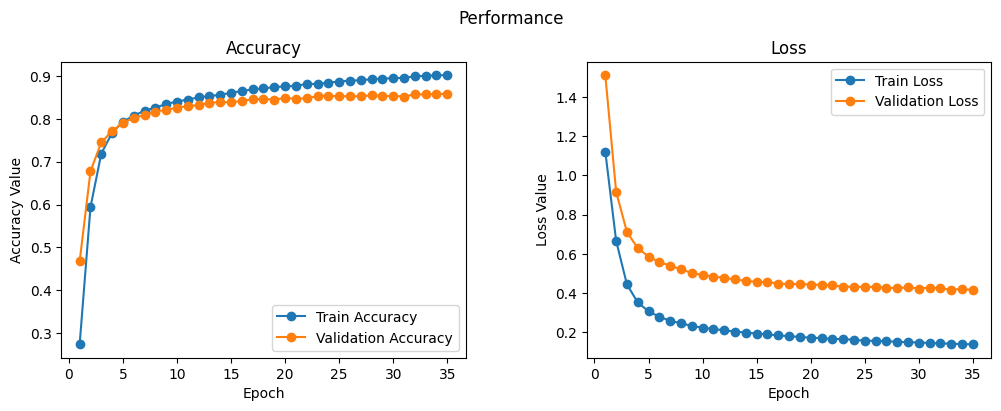

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs3+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs3+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs3+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
# Save the seniorstudent_model
filename = 'student_model.sav'
pickle.dump(student, open(filename, 'wb'))

In [ ]:
classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = student(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.8489
Confusion Matrix: 
 [[786   3  23  45   5   2 124   0  12   0]
 [  3 959   5  24   6   0   3   0   0   0]
 [ 15   5 762  13 113   0  82   0  10   0]
 [ 24  12  11 878  45   0  25   0   5   0]
 [  1   1 101  41 738   0 109   0   9   0]
 [  0   0   0   1   0 946   0  33   6  14]
 [144   4 102  48  89   0 593   0  20   0]
 [  0   0   0   0   0  24   0 942   0  34]
 [  3   1   7   5   3   8   8   7 956   2]
 [  0   0   0   0   0  12   0  58   1 929]]
Performance Report: 
               precision    recall  f1-score   support

 T-shirt/top       0.81      0.79      0.80      1000
     Trouser       0.97      0.96      0.97      1000
    Pullover       0.75      0.76      0.76      1000
       Dress       0.83      0.88      0.85      1000
        Coat       0.74      0.74      0.74      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.63      0.59      0.61      1000
     Sneaker       0.91      0.94      0.92      1000
         Bag       0.94